In [1]:
import sys, os, glob
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from libs.activations import lrelu
import math
import numpy as np
import random as rnd

In [13]:
tf.reset_default_graph()

# %%
# define parameters for input sizes and filters for autoencoder layers
batch_size = 1
input_shape = [batch_size, 40, 320, 1]
n_filters = [1, 70, 70, 70]
filter_sizes = [[8, 10], [8, 14], [2, 8]]
strides_i = [[4, 5], [1, 7], [1, 1]]
    
# %%
# input to the network
x = tf.placeholder(tf.float32, input_shape, name='x')

# %%
# ensure input is 4-d.
if len(x.get_shape()) == 4:
    x_tensor = x
else:
    raise ValueError('Unsupported input dimensions')
current_input = x_tensor

# %%
# Build the encoder
encoder = []
bias_list = []
shapes = []
# Zs = []
# beta = 50
# betas = []
for layer_i, n_output in enumerate(n_filters[1:]):
    n_input = current_input.get_shape().as_list()[3]
    shapes.append(current_input.get_shape().as_list())
    W = tf.Variable(
        tf.random_uniform([filter_sizes[layer_i][0], filter_sizes[layer_i][1], n_input, n_output],
            -1.0 / math.sqrt(n_input), 1.0 / math.sqrt(n_input)))
    encoder.append(W)
    b = tf.Variable(tf.zeros([n_output]))
    bias_list.append(b)
    output = lrelu(
        tf.add(tf.nn.conv2d(
            current_input, W, strides=[1, strides_i[layer_i][0], strides_i[layer_i][1], 1], padding='VALID'), b))
#     if layer_i > 2:
#         Zs.append(output)
#         beta *= 5.0
#         betas.append(beta)
    print('layer ', layer_i, 'has output shape =', output.get_shape())
    current_input = output

# %%
# the latent representation
z = current_input
z_shape = z.get_shape()
print('z.shape =', z_shape) #, 'beta =', beta)

# %%
# create head and place cells
z_flat = tf.reshape(z, [-1, z_shape[1]*z_shape[2]*z_shape[3]])
Head = tf.layers.dense(inputs=z_flat, units=40, activation=lrelu, name='head')
Place = tf.layers.dense(inputs=z_flat, units=30, activation=lrelu, name='place')
# HeadAndPlace = tf.concat([Head, Place], 1)
print('Head shape =', Head.get_shape(), 'Place shape =', Place.get_shape()) #, 'HeadAndPlace shape =', HeadAndPlace.get_shape())
z_head_out = tf.layers.dense(inputs=Head, units=z_shape[1]*z_shape[2]*z_shape[3], activation=lrelu, name='z_head')
z_place_out = tf.layers.dense(inputs=Place, units=z_shape[1]*z_shape[2]*z_shape[3], activation=lrelu, name='z_place')
z_out = z_head_out + z_place_out
current_input = tf.reshape(z_out, [-1, z_shape[1], z_shape[2], z_shape[3]])
print('z_out shape =', current_input.get_shape())

Head_variables = []
Place_variables = []
for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
#     print(v.name)
    if v.name == Head.name.split('/')[0] + '/kernel:0':
        Head_weights = v
        Head_variables.append(Head_weights)
    if v.name == Head.name.split('/')[0] + '/bias:0':
        Head_bias = v
        Head_variables.append(Head_bias)
    if v.name == Place.name.split('/')[0] + '/kernel:0':
        Place_weights = v
        Place_variables.append(Place_weights)
    if v.name == Place.name.split('/')[0] + '/bias:0':
        Place_bias = v
        Place_variables.append(Place_bias)
    if v.name == z_head_out.name.split('/')[0] + '/kernel:0':
        z_head_out_weights = v
        Head_variables.append(z_head_out_weights)
    if v.name == z_head_out.name.split('/')[0] + '/bias:0':
        z_head_out_bias = v
        Head_variables.append(z_head_out_bias)
    if v.name == z_place_out.name.split('/')[0] + '/kernel:0':
        z_place_out_weights = v
        Place_variables.append(z_place_out_weights)
    if v.name == z_place_out.name.split('/')[0] + '/bias:0':
        z_place_out_bias = v
        Place_variables.append(z_place_out_bias)

encoder.reverse()
shapes.reverse()
strides_i.reverse()

# %%
# Build the decoder using the same weights
for layer_i, shape in enumerate(shapes):
    W = encoder[layer_i]
    b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
    bias_list.append(b)
    output = lrelu(tf.add(
        tf.nn.conv2d_transpose(
            current_input, W,
            tf.stack([x.get_shape()[0], shape[1], shape[2], shape[3]]),
            strides=[1, strides_i[layer_i][0], strides_i[layer_i][1], 1], padding='VALID'), b))
#     if layer_i == 0:
#         Zs.append(output)
#         beta = beta/10.0
#         betas.append(beta)
    print('layer ', layer_i, 'has output shape =', output.get_shape())
    current_input = output

# %%
# the reconstruction through the network
y = current_input
# cost function measures pixel-wise difference
cost1 = tf.reduce_sum(tf.square(y - x_tensor))
cost = cost1

# %%
# define action relevant costs on saved layers
# steps = tf.placeholder(tf.float32, [batch_size-1], name='steps')
# angles = tf.placeholder(tf.float32, [batch_size-1], name='angles')
# cost2s = []
# print('betas =', betas)

# for idx, tmp in enumerate(Zs):
#     print(idx, 'beta =', betas[idx], 'tmp.shape =', tmp.shape)
#     Head, Place = tf.split(tmp, [40, 30], 3)
#     Head1 = Head[0:batch_size-1, :, :, :]
#     Head2 = Head[1:batch_size, :, :, :]
#     Place1 = Place[0:batch_size-1, :, :, :]
#     Place2 = Place[1:batch_size, :, :, :]
#     cost2 = tf.reduce_sum((steps != 0)*tf.reduce_sum(tf.pow((Head1-Head2), 2), [1, 2, 3]))\
#         + tf.reduce_sum((angles != 0)*tf.reduce_sum(tf.pow((Place1-Place2), 2), [1, 2, 3]))
#     cost2s.append(cost2)
#     cost += betas[idx]*cost2

# %%
# dict for inputs, outputs, and costs
ae = {'x': x,\
      'z': z, 'Head': Head, 'Place': Place, 'y': y,\
      'cost': cost, 'cost1': cost1}

# %%
# define the optimizer
# Head_weights, Head_bias, z_head_out_weights, z_head_out_bias
# Place_weights, Place_bias, z_place_out_weights, z_place_out_bias
learning_rate = 0.001
trainable_variable_list1 = encoder + bias_list + Head_variables
optimizer1 = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'], var_list = trainable_variable_list1)

trainable_variable_list2 = encoder + bias_list + Place_variables
optimizer2 = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'], var_list = trainable_variable_list2)

optimizer3 = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])

layer  0 has output shape = (1, 9, 63, 70)
layer  1 has output shape = (1, 2, 8, 70)
layer  2 has output shape = (1, 1, 1, 70)
z.shape = (1, 1, 1, 70)
Head shape = (1, 40) Place shape = (1, 30)
z_out shape = (1, 1, 1, 70)
layer  0 has output shape = (1, 2, 8, 70)
layer  1 has output shape = (1, 9, 63, 70)
layer  2 has output shape = (1, 40, 320, 1)


In [14]:
for i in trainable_variable_list1:
    print(i)

print('.............................................................')
    
for i in trainable_variable_list2:
    print(i)

<tf.Variable 'Variable_4:0' shape=(2, 8, 70, 70) dtype=float32_ref>
<tf.Variable 'Variable_2:0' shape=(8, 14, 70, 70) dtype=float32_ref>
<tf.Variable 'Variable:0' shape=(8, 10, 1, 70) dtype=float32_ref>
<tf.Variable 'Variable_1:0' shape=(70,) dtype=float32_ref>
<tf.Variable 'Variable_3:0' shape=(70,) dtype=float32_ref>
<tf.Variable 'Variable_5:0' shape=(70,) dtype=float32_ref>
<tf.Variable 'Variable_6:0' shape=(70,) dtype=float32_ref>
<tf.Variable 'Variable_7:0' shape=(70,) dtype=float32_ref>
<tf.Variable 'Variable_8:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'head/kernel:0' shape=(70, 40) dtype=float32_ref>
<tf.Variable 'head/bias:0' shape=(40,) dtype=float32_ref>
<tf.Variable 'z_head/kernel:0' shape=(40, 70) dtype=float32_ref>
<tf.Variable 'z_head/bias:0' shape=(70,) dtype=float32_ref>
.............................................................
<tf.Variable 'Variable_4:0' shape=(2, 8, 70, 70) dtype=float32_ref>
<tf.Variable 'Variable_2:0' shape=(8, 14, 70, 70) dtype=float32_ref>

<class 'numpy.ndarray'> (40000, 40, 320, 1)
mean_img.shape = (40, 320, 1)
<class 'numpy.ndarray'> (39999, 3)
(39999,) (39999,)
<class 'numpy.ndarray'> (40000, 40, 320, 1)
mean_img2.shape = (40, 320, 1)
<class 'numpy.ndarray'> (39999, 3)
(39999,) (39999,)


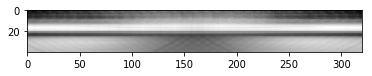

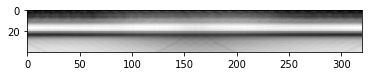

In [15]:
# %%
# load training image
train_images = np.load('train_images.npy')
print(type(train_images), train_images.shape)
mean_img = np.mean(train_images, axis=0)
print('mean_img.shape =', mean_img.shape)
plt.figure()
plt.imshow(mean_img[:, :, 0], cmap='gray')

# load training cmd
train_cmds = np.load("train_cmds.npy")
print(type(train_cmds), train_cmds.shape)
train_steps = train_cmds[:, 0]
train_angles = train_cmds[:, 1]
print(train_steps.shape, train_angles.shape)

# load training image2
train_images2 = np.load('train_images2.npy')
print(type(train_images2), train_images2.shape)
mean_img2 = np.mean(train_images2, axis=0)
print('mean_img2.shape =', mean_img2.shape)
plt.figure()
plt.imshow(mean_img2[:, :, 0], cmap='gray')

# load training cmd2
train_cmds2 = np.load("train_cmds2.npy")
print(type(train_cmds2), train_cmds2.shape)
train_steps2 = train_cmds2[:, 0]
train_angles2 = train_cmds2[:, 1]
print(train_steps2.shape, train_angles2.shape)

In [16]:
# %%
# initialize the weights or load the trained weights
sess = tf.Session()
saved_model = 'modelxxx'

sess.run(tf.global_variables_initializer())

# restorer = tf.train.Saver()
# restorer.restore(sess, 'model/' + saved_model)

In [17]:
# %%
# Fit training data
n_epochs = 30
for epoch_i in range(n_epochs):
    for batch_i in range(train_images.shape[0]):
        batch_xs = train_images[batch_i:(batch_i+batch_size), :, :, :]
        train = np.array([img - mean_img for img in batch_xs])
        if epoch_i != 0:
            steps_train = train_steps[batch_i-1]
            angles_train = train_angles[batch_i-1]
        else:
            steps_train = 0
            angles_train = 0
        if steps_train != 0:
            sess.run(optimizer2, feed_dict={ae['x']: train})
        elif angles_train != 0:
            sess.run(optimizer1, feed_dict={ae['x']: train})
        else:
            sess.run(optimizer3, feed_dict={ae['x']: train})
        if batch_i % 4000 == 0:
            cost, head_val, place_val = sess.run([ae['cost'], ae['Head'], ae['Place']], feed_dict={ae['x']: train})
            print(epoch_i, batch_i, 'cost =', cost, '\n\tHead:', head_val, '\n\tPlace:', place_val)
        #     print('z.shape =', z.shape, '\n', np.reshape(z, (batch_size, 70)))
    for batch_i in range(train_images.shape[0]):
        batch_xs = train_images2[batch_i:(batch_i+batch_size), :, :, :]
        train = np.array([img - mean_img2 for img in batch_xs])
        if epoch_i != 0:
            steps_train = train_steps2[batch_i-1]
            angles_train = train_angles2[batch_i-1]
        else:
            steps_train = 0
            angles_train = 0
        if steps_train != 0:
            sess.run(optimizer2, feed_dict={ae['x']: train})
        elif angles_train != 0:
            sess.run(optimizer1, feed_dict={ae['x']: train})
        else:
            sess.run(optimizer3, feed_dict={ae['x']: train})
        if batch_i % 4000 == 0:
            cost, head_val, place_val = sess.run([ae['cost'], ae['Head'], ae['Place']], feed_dict={ae['x']: train})
            print(epoch_i, batch_i, 'cost =', cost, '\n\tHead:', head_val, '\n\tPlace:', place_val)
        #     print('z.shape =', z.shape, '\n', np.reshape(z, (batch_size, 70)))

# %%
# Plot example reconstructions
example_num = 4
start = int(rnd.random()*(40000-example_num-1))
test_xs = train_images[start:(start+example_num), :, :, :]
test_xs_norm = np.array([img - mean_img for img in test_xs])
steps_test = train_steps[start:(start+example_num-1)]
angles_test = train_angles[start:(start+example_num-1)]
print(steps_test, angles_test)
recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})

test_xs2 = train_images2[start:(start+example_num), :, :, :]
test_xs_norm = np.array([img - mean_img2 for img in test_xs2])
steps_test = train_steps2[start:(start+example_num-1)]
angles_test = train_angles2[start:(start+example_num-1)]
print(steps_test, angles_test)
recon2 = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})

test_xs = np.concatenate((test_xs, test_xs2), axis=0)
recon = np.concatenate((recon, recon2), axis=0)
print(test_xs.shape, recon.shape)
fig, axs = plt.subplots(example_num*2, 2, figsize=(18, 16))
for example_i in range(example_num*2):
    axs[example_i][0].imshow(test_xs[example_i, :, :, 0], cmap='gray')
    if example_i < 10:
        axs[example_i][1].imshow(recon[example_i, :, :, 0] + mean_img[:, :, 0], cmap='gray')
    else:
        axs[example_i][1].imshow(recon[example_i, :, :, 0] + mean_img2[:, :, 0], cmap='gray')
plt.show()

saver = tf.train.Saver()
save_path = saver.save(sess, 'model/' + saved_model)
print("Model saved in file: %s" % save_path)

0 0 cost = 147177.0 
	Head: [[-1.15340734 -0.07162882 -1.44223976  0.28669626 -2.14469576 -0.3284331
  -0.23985347 -1.74800348  4.48789692  6.65029716  2.8814702  -0.53378034
   1.22715938 -0.07507667 -0.78941858 -0.07454477 -0.96589935 -1.4214704
  -0.36244714 -0.29611456 -0.49972534 -0.93608952 -0.89481819 -1.50592017
   4.49458981  3.22062016 -0.84210038 -0.19136339 -0.66698396 -0.35427725
  -1.15128779 -0.93996894  1.09517598  3.84167576 -0.96189296 -0.0820242
   1.58948517 -0.18884256  2.79592228 -0.78014553]] 
	Place: [[-0.93799865 -0.9045223   3.50760174 -0.8801049  -0.9304589  -1.21041322
   1.90826035  2.22958994  8.31851292  6.71051502 -2.0703125  -0.04041564
   2.58193445 -0.80988729  2.20309639  3.62512541 -1.02606583  2.71043158
   0.17038806 -0.79278696  2.94424391  0.38767594  3.43780351  1.34164095
  -1.61546302 -0.33073109 -0.20978838 -0.21330267 -1.25369048 -0.64716303]]
0 4000 cost = 331.875 
	Head: [[-0.32257926 -0.41279101 -0.37397671 -0.56838727 -0.25717366 -0.083

0 36000 cost = 307.81 
	Head: [[-4.99077702 -7.37499619 -1.90467072 -5.063097   -0.85699308 -4.18990421
  -2.43707037 -0.64466107 -2.76236391 -3.39199591 -1.62795329 -3.53752851
  -1.56153631 -4.49472904 -9.59046745 -9.85038185 -3.69515228 -1.99223089
  -2.33326101 -2.19078732 -4.91103649 -4.60676098 -2.88145161 -3.45762587
  -0.90333605 -4.09124756 -1.57111669 -1.59308004 -6.16770554 -1.09187055
  -2.55144596 -2.59091902 -1.74412584 -2.61060953 -2.94343042 -3.07402039
  -5.12720299 -2.06938267 -2.58532476 -6.68910122]] 
	Place: [[ 0.09289703 -6.94207001  2.21639633 -0.76890659 -1.63185072 -0.5121181
  -3.07851839 -2.31187201 -4.10426426 -9.6006279  -3.70824385 -4.42286873
  -2.64132071 -1.17675185 -1.62406445 -0.86102474 -4.81168079 -7.70477867
  -2.48417711 -2.18304968 -3.26910353 -2.83526802 -3.64416981 -8.66182899
  -2.33167267 -2.46315002 -3.09014463 -3.49836683 -1.93803    -0.27940446]]
0 0 cost = 282.204 
	Head: [[-7.31674862 -6.27894211 -2.75479412 -5.50430965 -2.7762804  -3.03

KeyboardInterrupt: 

# Head and Place Cells Test

(12096, 40, 320, 1)
test_mean_img.shape = (40, 320, 1)
(12096, 3)
(12096,) 24
{3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0}
(12096,) 14
{3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0}
(12096,) 36
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0}


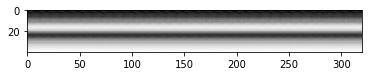

In [6]:
# load test data
test_images = np.load('test_images.npy')
print(test_images.shape)
test_mean_img = np.mean(test_images, axis=0)
print('test_mean_img.shape =', test_mean_img.shape)
plt.imshow(test_mean_img[:, :, 0], cmap='gray')

test_cmds = np.load('test_cmds.npy')
print(test_cmds.shape)
test_xs = test_cmds[:, 0]
test_x_set = set(test_xs)
print(test_xs.shape, len(test_x_set))
print(test_x_set)
test_ys = test_cmds[:, 1]
test_y_set = set(test_ys)
print(test_ys.shape, len(test_y_set))
print(test_y_set)
test_angles = test_cmds[:, 2]
test_angle_set = set(test_angles)
print(test_angles.shape, len(test_angle_set))
print(test_angle_set)

In [7]:
head_map_4_head_cell = np.zeros((36, 40))
place_map_4_head_cell = np.zeros((14, 24, 40))
head_map_4_place_cell = np.zeros((36, 30))
place_map_4_place_cell = np.zeros((14, 24, 30))

for idx in range(test_images.shape[0] // batch_size):
    batch_xs = test_images[(idx*batch_size):((idx+1)*batch_size), :, :, :]
    test_image = np.array([img - test_mean_img for img in batch_xs])
    test_x = test_xs[(idx*batch_size):((idx+1)*batch_size)]
    test_y = test_ys[(idx*batch_size):((idx+1)*batch_size)]
    test_angle = test_angles[(idx*batch_size):((idx+1)*batch_size)]
    Head_val, Place_val = sess.run([ae['Head'], ae['Place']], feed_dict={ae['x']: test_image})
    print(idx, 'Head_val.shape =', Head_val.shape, 'Place_val.shape =', Place_val.shape)
    for idx2 in range(batch_size):
        head_map_4_head_cell[test_angle[idx2].astype(int), :] += np.mean(Head_val, (1, 2))[idx2, :]
        place_map_4_head_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += np.mean(Head_val, (1, 2))[idx2, :]
        head_map_4_place_cell[test_angle[idx2].astype(int), :] += np.mean(Place_val, (1, 2))[idx2, :]
        place_map_4_place_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += np.mean(Place_val, (1, 2))[idx2, :]

0 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
6 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
7 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
8 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
9 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
10 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
11 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
12 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
13 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
14 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
15 Head_val.shape = 

125 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
126 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
127 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
128 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
129 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
130 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
131 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
132 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
133 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
134 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
135 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
136 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
137 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
138 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
139 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1,

252 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
253 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
254 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
255 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
256 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
257 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
258 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
259 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
260 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
261 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
262 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
263 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
264 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
265 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
266 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1,

380 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
381 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
382 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
383 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
384 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
385 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
386 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
387 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
388 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
389 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
390 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
391 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
392 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
393 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
394 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1,

510 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
511 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
512 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
513 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
514 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
515 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
516 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
517 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
518 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
519 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
520 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
521 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
522 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
523 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
524 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1,

641 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
642 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
643 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
644 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
645 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
646 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
647 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
648 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
649 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
650 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
651 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
652 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
653 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
654 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
655 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1,

773 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
774 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
775 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
776 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
777 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
778 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
779 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
780 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
781 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
782 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
783 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
784 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
785 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
786 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
787 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1,

898 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
899 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
900 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
901 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
902 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
903 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
904 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
905 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
906 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
907 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
908 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
909 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
910 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
911 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
912 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1,

1031 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1032 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1033 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1034 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1035 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1036 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1037 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1038 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1039 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1040 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1041 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1042 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1043 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1044 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1045 Head_val.shape = (2, 1, 1, 40) Place_val.sh

1158 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1159 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1160 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1161 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1162 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1163 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1164 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1165 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1166 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1167 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1168 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1169 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1170 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1171 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1172 Head_val.shape = (2, 1, 1, 40) Place_val.sh

1291 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1292 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1293 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1294 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1295 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1296 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1297 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1298 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1299 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1300 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1301 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1302 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1303 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1304 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1305 Head_val.shape = (2, 1, 1, 40) Place_val.sh

1424 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1425 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1426 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1427 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1428 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1429 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1430 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1431 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1432 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1433 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1434 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1435 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1436 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1437 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1438 Head_val.shape = (2, 1, 1, 40) Place_val.sh

1552 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1553 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1554 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1555 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1556 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1557 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1558 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1559 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1560 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1561 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1562 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1563 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1564 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1565 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1566 Head_val.shape = (2, 1, 1, 40) Place_val.sh

1674 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1675 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1676 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1677 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1678 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1679 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1680 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1681 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1682 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1683 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1684 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1685 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1686 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1687 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1688 Head_val.shape = (2, 1, 1, 40) Place_val.sh

1803 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1804 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1805 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1806 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1807 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1808 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1809 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1810 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1811 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1812 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1813 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1814 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1815 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1816 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1817 Head_val.shape = (2, 1, 1, 40) Place_val.sh

1932 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1933 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1934 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1935 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1936 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1937 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1938 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1939 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1940 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1941 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1942 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1943 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1944 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1945 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
1946 Head_val.shape = (2, 1, 1, 40) Place_val.sh

2054 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2055 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2056 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2057 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2058 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2059 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2060 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2061 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2062 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2063 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2064 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2065 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2066 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2067 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2068 Head_val.shape = (2, 1, 1, 40) Place_val.sh

2178 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2179 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2180 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2181 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2182 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2183 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2184 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2185 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2186 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2187 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2188 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2189 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2190 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2191 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2192 Head_val.shape = (2, 1, 1, 40) Place_val.sh

2301 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2302 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2303 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2304 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2305 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2306 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2307 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2308 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2309 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2310 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2311 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2312 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2313 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2314 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2315 Head_val.shape = (2, 1, 1, 40) Place_val.sh

2431 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2432 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2433 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2434 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2435 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2436 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2437 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2438 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2439 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2440 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2441 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2442 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2443 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2444 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2445 Head_val.shape = (2, 1, 1, 40) Place_val.sh

2557 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2558 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2559 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2560 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2561 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2562 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2563 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2564 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2565 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2566 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2567 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2568 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2569 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2570 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2571 Head_val.shape = (2, 1, 1, 40) Place_val.sh

2683 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2684 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2685 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2686 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2687 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2688 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2689 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2690 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2691 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2692 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2693 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2694 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2695 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2696 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2697 Head_val.shape = (2, 1, 1, 40) Place_val.sh

2818 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2819 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2820 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2821 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2822 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2823 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2824 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2825 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2826 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2827 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2828 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2829 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2830 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2831 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2832 Head_val.shape = (2, 1, 1, 40) Place_val.sh

2947 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2948 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2949 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2950 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2951 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2952 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2953 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2954 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2955 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2956 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2957 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2958 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2959 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2960 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
2961 Head_val.shape = (2, 1, 1, 40) Place_val.sh

3078 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3079 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3080 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3081 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3082 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3083 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3084 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3085 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3086 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3087 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3088 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3089 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3090 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3091 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3092 Head_val.shape = (2, 1, 1, 40) Place_val.sh

3204 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3205 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3206 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3207 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3208 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3209 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3210 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3211 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3212 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3213 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3214 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3215 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3216 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3217 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3218 Head_val.shape = (2, 1, 1, 40) Place_val.sh

3334 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3335 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3336 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3337 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3338 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3339 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3340 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3341 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3342 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3343 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3344 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3345 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3346 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3347 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3348 Head_val.shape = (2, 1, 1, 40) Place_val.sh

3464 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3465 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3466 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3467 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3468 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3469 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3470 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3471 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3472 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3473 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3474 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3475 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3476 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3477 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3478 Head_val.shape = (2, 1, 1, 40) Place_val.sh

3591 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3592 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3593 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3594 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3595 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3596 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3597 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3598 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3599 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3600 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3601 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3602 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3603 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3604 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3605 Head_val.shape = (2, 1, 1, 40) Place_val.sh

3721 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3722 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3723 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3724 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3725 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3726 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3727 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3728 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3729 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3730 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3731 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3732 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3733 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3734 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3735 Head_val.shape = (2, 1, 1, 40) Place_val.sh

3850 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3851 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3852 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3853 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3854 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3855 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3856 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3857 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3858 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3859 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3860 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3861 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3862 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3863 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3864 Head_val.shape = (2, 1, 1, 40) Place_val.sh

3981 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3982 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3983 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3984 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3985 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3986 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3987 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3988 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3989 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3990 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3991 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3992 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3993 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3994 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
3995 Head_val.shape = (2, 1, 1, 40) Place_val.sh

4106 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4107 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4108 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4109 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4110 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4111 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4112 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4113 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4114 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4115 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4116 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4117 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4118 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4119 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4120 Head_val.shape = (2, 1, 1, 40) Place_val.sh

4236 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4237 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4238 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4239 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4240 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4241 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4242 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4243 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4244 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4245 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4246 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4247 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4248 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4249 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4250 Head_val.shape = (2, 1, 1, 40) Place_val.sh

4364 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4365 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4366 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4367 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4368 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4369 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4370 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4371 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4372 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4373 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4374 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4375 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4376 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4377 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4378 Head_val.shape = (2, 1, 1, 40) Place_val.sh

4495 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4496 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4497 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4498 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4499 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4500 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4501 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4502 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4503 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4504 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4505 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4506 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4507 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4508 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4509 Head_val.shape = (2, 1, 1, 40) Place_val.sh

4634 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4635 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4636 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4637 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4638 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4639 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4640 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4641 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4642 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4643 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4644 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4645 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4646 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4647 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4648 Head_val.shape = (2, 1, 1, 40) Place_val.sh

4768 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4769 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4770 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4771 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4772 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4773 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4774 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4775 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4776 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4777 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4778 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4779 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4780 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4781 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4782 Head_val.shape = (2, 1, 1, 40) Place_val.sh

4902 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4903 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4904 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4905 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4906 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4907 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4908 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4909 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4910 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4911 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4912 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4913 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4914 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4915 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
4916 Head_val.shape = (2, 1, 1, 40) Place_val.sh

5039 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5040 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5041 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5042 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5043 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5044 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5045 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5046 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5047 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5048 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5049 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5050 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5051 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5052 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5053 Head_val.shape = (2, 1, 1, 40) Place_val.sh

5173 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5174 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5175 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5176 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5177 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5178 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5179 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5180 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5181 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5182 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5183 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5184 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5185 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5186 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5187 Head_val.shape = (2, 1, 1, 40) Place_val.sh

5310 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5311 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5312 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5313 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5314 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5315 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5316 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5317 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5318 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5319 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5320 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5321 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5322 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5323 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5324 Head_val.shape = (2, 1, 1, 40) Place_val.sh

5445 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5446 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5447 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5448 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5449 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5450 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5451 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5452 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5453 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5454 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5455 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5456 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5457 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5458 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5459 Head_val.shape = (2, 1, 1, 40) Place_val.sh

5581 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5582 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5583 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5584 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5585 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5586 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5587 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5588 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5589 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5590 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5591 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5592 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5593 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5594 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5595 Head_val.shape = (2, 1, 1, 40) Place_val.sh

5718 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5719 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5720 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5721 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5722 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5723 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5724 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5725 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5726 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5727 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5728 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5729 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5730 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5731 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5732 Head_val.shape = (2, 1, 1, 40) Place_val.sh

5858 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5859 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5860 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5861 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5862 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5863 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5864 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5865 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5866 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5867 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5868 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5869 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5870 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5871 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5872 Head_val.shape = (2, 1, 1, 40) Place_val.sh

5997 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5998 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
5999 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
6000 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
6001 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
6002 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
6003 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
6004 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
6005 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
6006 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
6007 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
6008 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
6009 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
6010 Head_val.shape = (2, 1, 1, 40) Place_val.shape = (2, 1, 1, 30)
6011 Head_val.shape = (2, 1, 1, 40) Place_val.sh

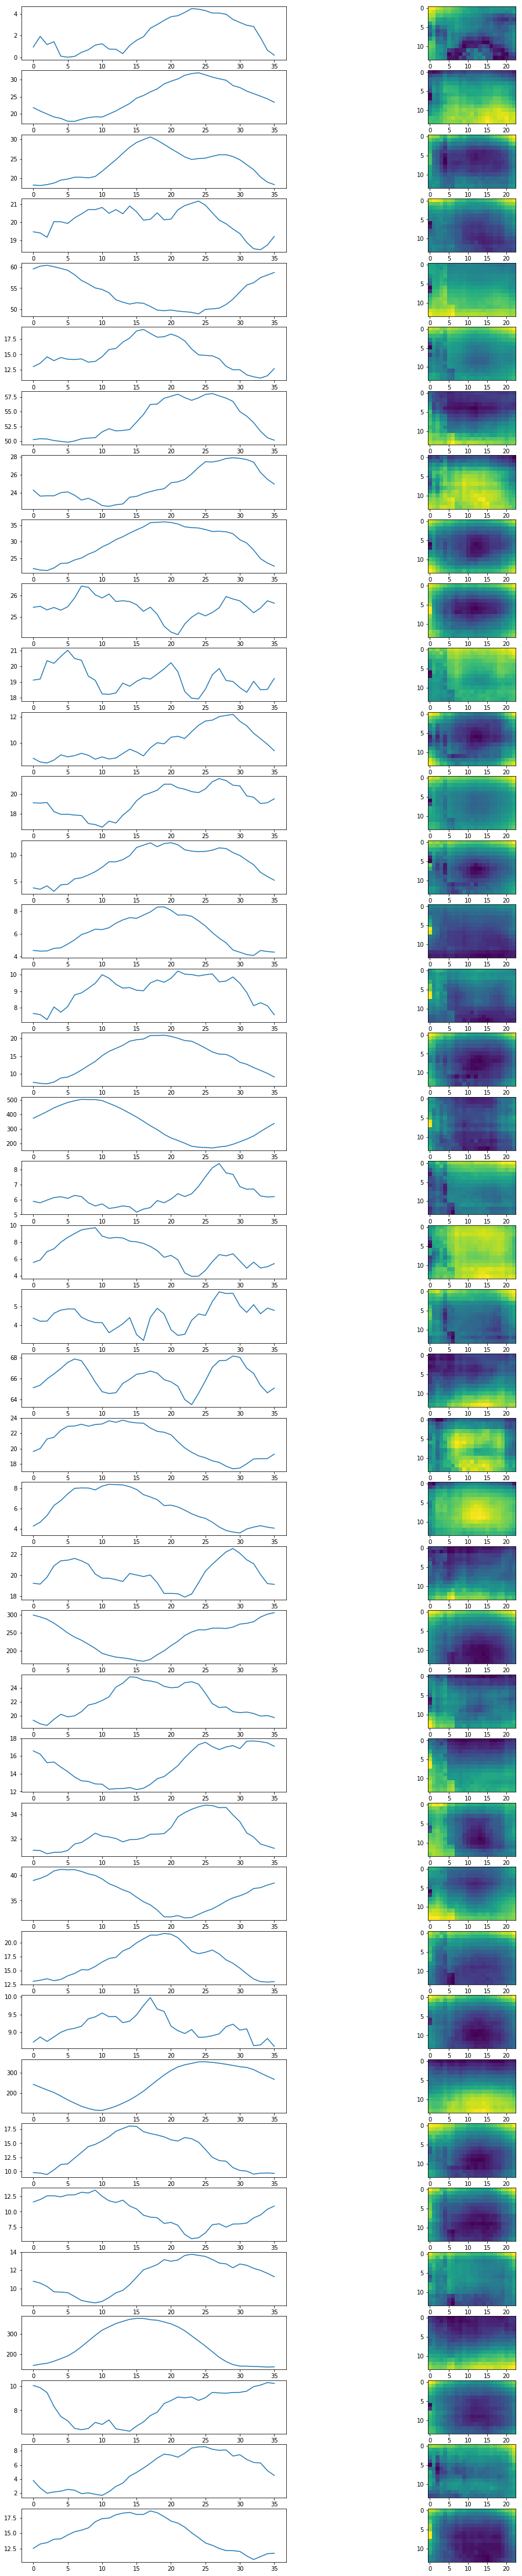

In [8]:
fig, axs = plt.subplots(40, 2, figsize=(18, 81))
for example_i in range(40):
    axs[example_i][0].plot(np.abs(head_map_4_head_cell[:, example_i]))
    axs[example_i][1].imshow(np.abs(place_map_4_head_cell[:, 0:23, example_i]))
plt.show()

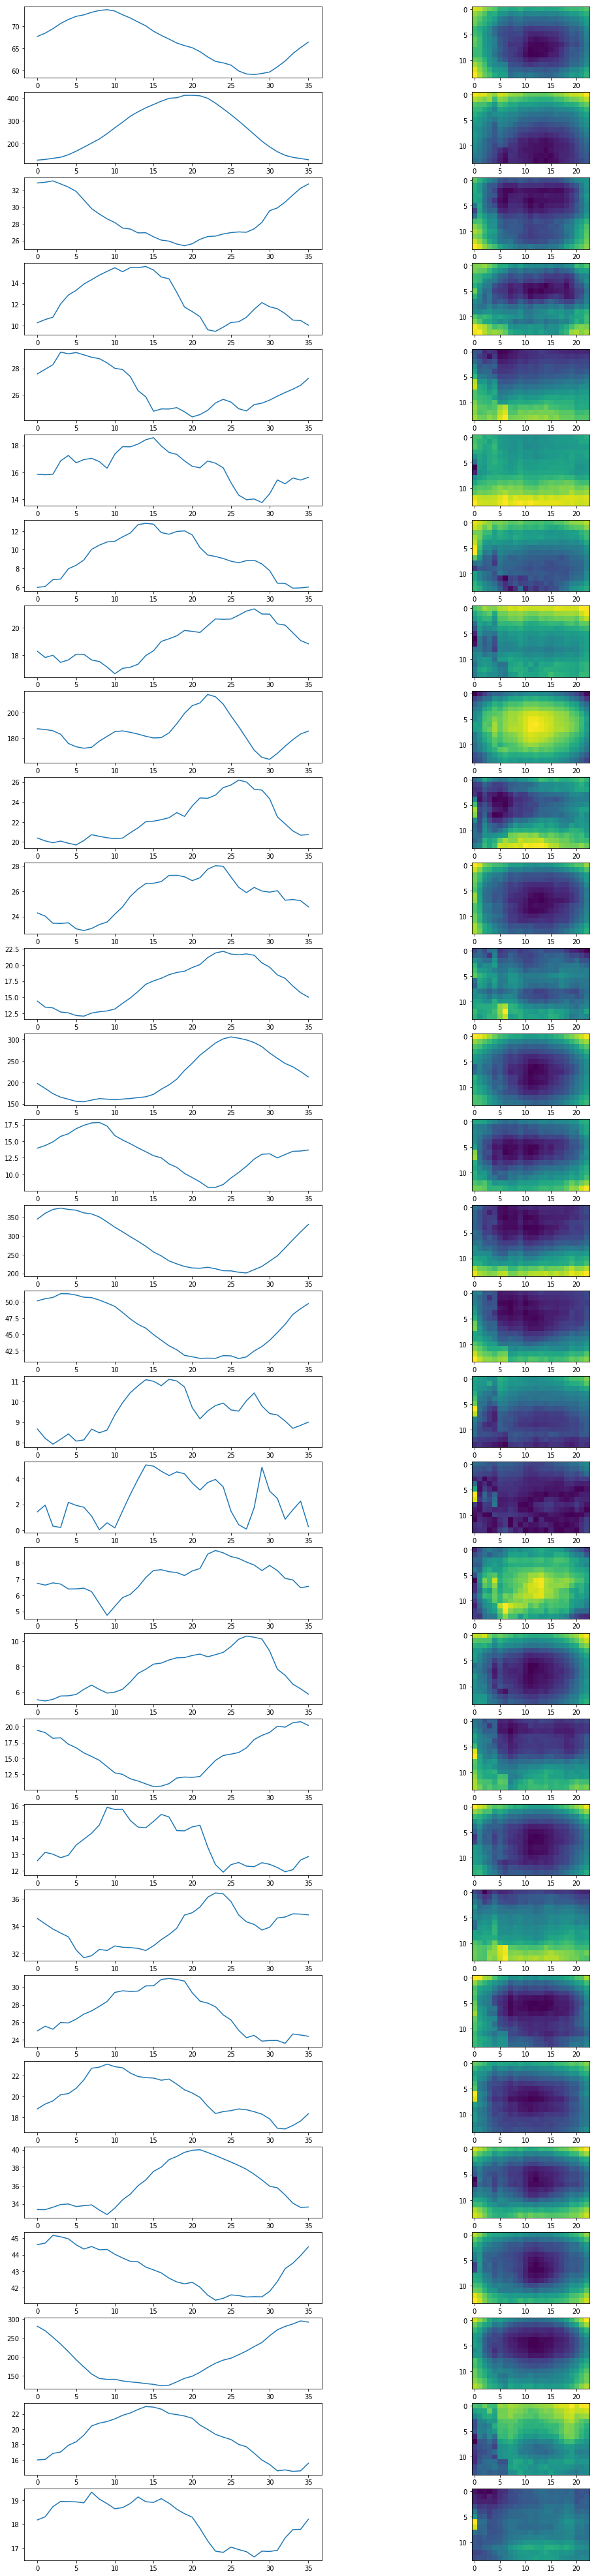

In [9]:
fig, axs = plt.subplots(30, 2, figsize=(18, 72))
for example_i in range(30):
    axs[example_i][0].plot(np.abs(head_map_4_place_cell[:, example_i]))
    axs[example_i][1].imshow(np.abs(place_map_4_place_cell[:, 0:23, example_i]))
plt.show()